<a href="https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/TextClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Wikipedia, as the name implies, is the Encyclopedia of the 21st century. It is an amazing place full of free information mantained by a community of volenteer editors. It has assisted in the removal of barriers when it comes to giving and receiving knwoledge. Unfortunatley, with this great democritization comes the potential spread of misinformation and plagarized content. With the rise of complex transformer models such as GPT2, AI can generate persuasive content that is practically identical to human written text. See what I mean!: https://techcrunch.com/2019/02/17/openai-text-generator-dangerous/

This is where machine learning can help! We can train a Machine learning model to classify whether or not a body of text has been written by a human or an AI and use other NLP strategies to catch plagarism. If this seems like a problem you care about then keep reading!

* Spencer Holley
* aacjpw@gmail.com
* https://github.com/spe301/Wikipedia-Capstone

# Use cases

* wikipedia users and contributers can flag AI generated articles
* prevent AI generated fake news from spreading
* teachers and professors can flag AI generated essays 

## Potosnail Library

I built a Python Package to make my workflow more effecient.
learn more at https://github.com/spe301/Potosnail

In [1]:
!pip install -q Potosnail==0.2.4

In [2]:
from potosnail import *
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as pyplot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.externals import joblib
from tensorflow.keras import models

In [3]:
#potosnail classes
ml = MachineLearning()
dl = DeepLearning()
dh = DataHelper()
ev = Evaluater()
al = Algorithms()
wr = Wrappers()
st = Stats()

# The Data
I scraped 1,000 articles on Wikipedia and trained GPT2 to generate 1,000 more articles based on the real articles. I will do Machine Learning, Deep Learning, and do some wordclouds and eda at the end.

See the scraper I built: https://github.com/spe301/Wikipedia-Capstone/blob/main/Scraper.py

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/Wikipedia2k.csv') #dataframe for EDA
train, val = dh.HoldOut(df)

vocab = len(set(','.join(df['Text']).split(' ')))
vocab #our 2,000 articles have 183,288 unique words, this will be the number of nodes in our embedding layer

183288

In [5]:
avg = 0
for i in range(len(df['Text'])):
  avg += len(list(df['Text'])[i].split(' '))/len(df)

pad = int(avg)
pad

1513

In [6]:
train, test = dh.HoldOut(df)

In [7]:
text, labels = dl.ModelReadyText1(train['Text'], train['AI'], pad)
Xtest, ytest = dl.ModelReadyText1(test['Text'], test['AI'], pad)

In [8]:
#quick inspection
#the average article has 1513 words
text.shape, labels.shape, vocab

((1800, 1513), (1800, 2), 183288)

In [9]:
Xtest.shape

(200, 1513)

#Modeling


## Giving good old Sklearn a try...

Before we nerd out with Deep Learning let's just see if we can accomplish our task with a traditional sklearn classifier. Deep Learning is awesome, but it is imporant to keep in mind that this dataset of 2,000 articles is still pretty small and therefore may not be ideal.

In [ ]:
X = pd.DataFrame(text)
y = train['AI']
ml.CompareModels(X, y, 'classification')

,Model,train_acc,test_acc
0,KNN,0.502222,0.420000
1,NB,0.765185,0.755556
2,DT,0.995556,0.824444
3,RF,0.995556,0.893333
4,AB,0.959259,0.862222
5,GB,0.980000,0.895556
6,Log,0.986667,0.784444
7,SVM,0.948889,0.862222


None of these models are looking great out of the box. However, the GradientBoostingClassifier aliased as GB looks the post promising so we will tune it.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier



GradientBoostingClassifier()

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
grid = {'learning_rate': [0.3, 0.5, 0.7], 'n_estimators': [144, 162, 180], 
            'criterion': ['friedman_mse', 'mse']}

model = GradientBoostingClassifier()
clf = ml.Optimize(model, grid, X, y)
clf

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 26.4min finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=162,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

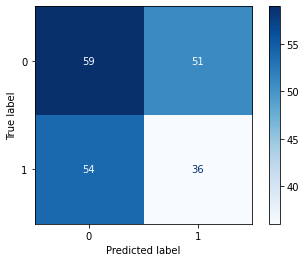

In [ ]:
ev.BuildConfusion(clf, pd.DataFrame(Xtest), val['AI'])

In [ ]:
clf.score(X, y)

0.9672222222222222

Although this model has 96.7% acctracy it is doing quite poorly on the validation data. It misclassified 60% of the fake articles and 55% of the real ones.

In [ ]:
joblib.dump(clf, 'drive/MyDrive/clf.pkl')

['drive/MyDrive/clf.pkl']

In [ ]:
model = joblib.load('drive/MyDrive/clf.pkl')

## Deep Learning

In [ ]:
#baseline feed forward neural network
model = dl.FastNN('classification', 'binary_crossentropy', output_dim=2, nodes=128, activation='tanh', dropout=True, stacking=True)
history = model.fit(text, labels, epochs=150, batch_size=32, validation_split=0.2)
model.summary()

Epoch 1/150
45/45 [==============================] - 1s 9ms/step - loss: 0.6891 - accuracy: 0.5870 - val_loss: 0.5735 - val_accuracy: 0.6861
Epoch 2/150
45/45 [==============================] - 0s 5ms/step - loss: 0.5655 - accuracy: 0.7094 - val_loss: 0.5147 - val_accuracy: 0.7722
Epoch 3/150
45/45 [==============================] - 0s 5ms/step - loss: 0.4713 - accuracy: 0.8019 - val_loss: 0.4996 - val_accuracy: 0.7889
Epoch 4/150
45/45 [==============================] - 0s 5ms/step - loss: 0.4018 - accuracy: 0.8283 - val_loss: 0.4807 - val_accuracy: 0.8083
Epoch 5/150
45/45 [==============================] - 0s 5ms/step - loss: 0.4176 - accuracy: 0.8262 - val_loss: 0.4203 - val_accuracy: 0.8333
Epoch 6/150
45/45 [==============================] - 0s 5ms/step - loss: 0.3877 - accuracy: 0.8428 - val_loss: 0.4581 - val_accuracy: 0.8194
Epoch 7/150
45/45 [==============================] - 0s 5ms/step - loss: 0.4478 - accuracy: 0.8222 - val_loss: 0.4751 - val_accuracy: 0.8222
Epoch 8/150
4

In [ ]:
model.evaluate(text, labels)

57/57 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.8850


[0.3150085210800171, 0.8849999904632568]

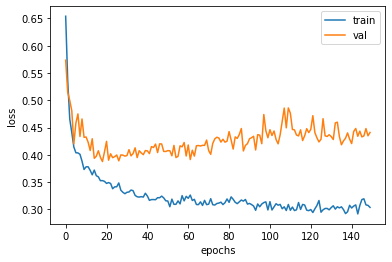

In [ ]:
ev.ViewLoss(history)

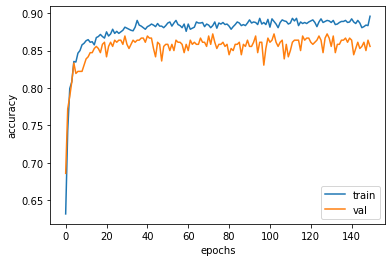

In [ ]:
ev.ViewAccuracy(history)

<AxesSubplot:xlabel='Predict', ylabel='True'>

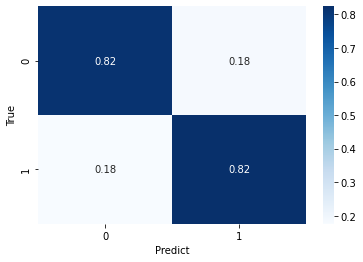

In [ ]:
ev.BuildConfusionDL(model, Xtest, ytest)

Although accuracy was lower at 88-89 percent, the validation is going much better. The model properly classified 82% of the articles among both classes.

Let's see what kind of results we can get with a gridsearch

In [ ]:
grid = {'output_dim': [2], 'nodes': [64, 96, 128], 'activation': ['tanh'], 'regularizer': [None], 
        'stacking': [True, False], 'dropout': [True, False], 'nlayers': list(range(3, 8)), 'closer': [False], 
        'loss_func': ['binary_crossentropy'], 'optimizer': ['adam', 'rmsprop']}

grid = dl.TestDL(grid, dl.DeepTabularClassification, 'classification', text, labels)
grid.best_estimator_.model.save('drive/MyDrive/dm.h5')

In [ ]:
grid.best_params_

## Trying out an RNN

In [ ]:
model3 = dl.FastRNN(2, vocab, nodes=32, bidirectional=True, regularizer='L1')
history = model3.fit(text, labels, epochs=10, batch_size=32, validation_split=0.2)
model3.summary()

Epoch 1/10
45/45 [==============================] - 48s 1s/step - loss: 0.6855 - accuracy: 0.5796 - val_loss: 0.5808 - val_accuracy: 0.7806
Epoch 2/10
45/45 [==============================] - 44s 983ms/step - loss: 0.5510 - accuracy: 0.7359 - val_loss: 0.3974 - val_accuracy: 0.8778
Epoch 3/10
45/45 [==============================] - 44s 985ms/step - loss: 0.3536 - accuracy: 0.8782 - val_loss: 0.3956 - val_accuracy: 0.8472
Epoch 4/10
45/45 [==============================] - 44s 987ms/step - loss: 0.1350 - accuracy: 0.9700 - val_loss: 0.4115 - val_accuracy: 0.8361
Epoch 5/10
45/45 [==============================] - 48s 1s/step - loss: 0.0737 - accuracy: 0.9849 - val_loss: 0.4432 - val_accuracy: 0.8222
Epoch 6/10
45/45 [==============================] - 44s 985ms/step - loss: 0.0639 - accuracy: 0.9860 - val_loss: 0.4733 - val_accuracy: 0.8194
Epoch 7/10
45/45 [==============================] - 45s 995ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 0.5004 - val_accuracy: 0.8250
Epoch

In [ ]:
model3.evaluate(Xtest, ytest)

7/7 [==============================] - 0s 46ms/step - loss: 0.8499 - accuracy: 0.7350


[0.8499387502670288, 0.7350000143051147]

<AxesSubplot:xlabel='Predict', ylabel='True'>

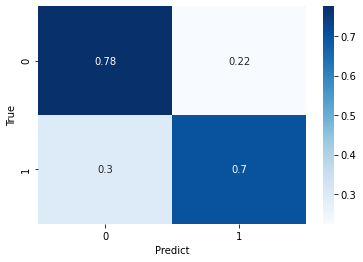

In [ ]:
ev.BuildConfusionDL(model3, Xtest, ytest)

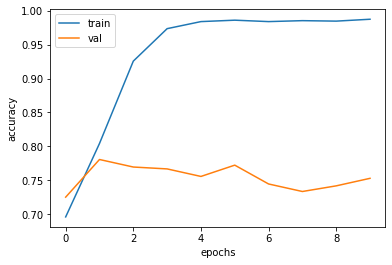

In [ ]:
ev.ViewAccuracy(history)

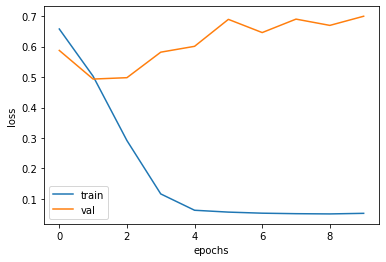

In [ ]:
ev.ViewLoss(history)

## RNN gridsearch

In [ ]:
params = {'output_dim': [2], #because we have 2 classes
          'embedding': [vocab], #vocab is number of unique words in dataset
          'nodes': [32, 64], #we will test between 32 and 64 nodes for the first layer
          'activation': ['tanh'], #we will test between relu and tanh for activation function
          'regularizer': ['L1', None], #we will use L1 reqularization to prevent overfitting
          'stacking': [False], #stacking makes the first 2 layers the same, we will not do this
          'dropout': [False, True], #we will not use dropout because we are already using L1 regularization
          'optimizer': ['adam'], #we will test between adam and rmsprop for optimization function
          'method': ['LSTM', 'GRU'], #we will test between using an LSTM cell and a GRU cell
          'bidirectional': [True, False]} #we will test between a bidirectional RNN and a standard RNN

grid = dl.TestDL(params, dl.RNN, 'classification', text, labels, batch_size=32)
grid.best_estimator_.model.save('drive/MyDrive/dm2.h5')

Epoch 1/50
30/30 [==============================] - 23s 169ms/step - loss: 0.6855 - accuracy: 0.5697 - val_loss: 0.6160 - val_accuracy: 0.7167
Epoch 2/50
30/30 [==============================] - 4s 133ms/step - loss: 0.5509 - accuracy: 0.7566 - val_loss: 0.9082 - val_accuracy: 0.5000
Epoch 3/50
30/30 [==============================] - 4s 133ms/step - loss: 0.7034 - accuracy: 0.5812 - val_loss: 0.6090 - val_accuracy: 0.6667
Epoch 4/50
30/30 [==============================] - 4s 134ms/step - loss: 0.3740 - accuracy: 0.9459 - val_loss: 0.7536 - val_accuracy: 0.6792
Epoch 5/50
30/30 [==============================] - 4s 133ms/step - loss: 0.1348 - accuracy: 0.9701 - val_loss: 0.7280 - val_accuracy: 0.7000
Epoch 6/50
30/30 [==============================] - 4s 133ms/step - loss: 0.1032 - accuracy: 0.9778 - val_loss: 0.8007 - val_accuracy: 0.7250
Epoch 7/50
30/30 [==============================] - 4s 134ms/step - loss: 0.0823 - accuracy: 0.9832 - val_loss: 0.7883 - val_accuracy: 0.7167
Epoch

In [ ]:
grid.best_params_

{'activation': 'tanh',
 'bidirectional': True,
 'dropout': False,
 'embedding': 183288,
 'method': 'LSTM',
 'nodes': 32,
 'optimizer': 'adam',
 'output_dim': 2,
 'regularizer': None,
 'stacking': False}

In [10]:
model4 = models.load_model('drive/MyDrive/dm2.h5')
# training accuracy
model4.evaluate(text, labels)

57/57 [==============================] - 18s 41ms/step - loss: 0.7740 - accuracy: 0.7261


[0.774020254611969, 0.726111114025116]

In [11]:
model4.evaluate(Xtest, ytest)

7/7 [==============================] - 0s 43ms/step - loss: 0.5455 - accuracy: 0.8050


[0.5455071926116943, 0.8050000071525574]

80% training accuracy and no overfitting

<AxesSubplot:xlabel='Predict', ylabel='True'>

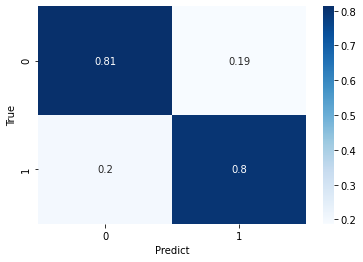

In [13]:
Evaluater().BuildConfusionDL(model4, Xtest, ytest)

# EDA

1. What would a wordcloud look like for these two seperate collections of text?

insight: first was a major word for both the AI written and Human written articles because the articles often mention that the topic was or is the first to do or be something in particular. United States and german were major in the AI written text because there were many political articles whereas the real articles used terms more general words, like may and many, because they were over a wider variety of topics

In [14]:
AI = ','.join(df.loc[df['AI']==1]['Text'])
Human = ','.join(df.loc[df['AI']==0]['Text'])

In [15]:
AiCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(AI)
HumanCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(Human)

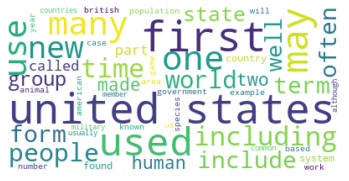

In [16]:
plt.imshow(AiCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

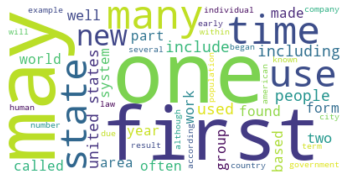

In [17]:
plt.imshow(HumanCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

# Reccomendations / Conculsions
These are some ways an AI written text classifier can be used

1. Teachers and professors can flag AI generated text in there student's work.
2. News companies can use this to verify that the news stories that come in really came from their reporters instead of a bot.
3. Wikipedia users and contributers can flag AI generated text on the site.

## Reccomendation for Data Scientists
I know deep learning can be tempting, but it is best practice to try a sklearn model to solve the problem first.